In [1]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
from sklearn import preprocessing
import numpy as np
import IPython


In [2]:
path_train = 'data/train_labels.csv'
path_test = 'data/test_files.csv'
df = pd.read_csv(path_train)
sample_rate = 1100
df['filename'] = df['filename'].map(lambda x: 'data/data/%04d.wav' % x)
print(len(df.index))
df.head(2)

1532


,filename,pasture,height,label
0,data/data/0004.wav,alfalfa,tall,2
1,data/data/0009.wav,alfalfa,tall,2


In [19]:
from math import floor
path_train = 'data/train_labels.csv'
path_test = 'data/test_files.csv'
num_cc = 70
df = pd.read_csv(path_train)
total_count = len(df.index)
num_test = floor(total_count * 0.18)
df['filename'] = df['filename'].map(lambda x: 'data/data/%04d.wav' % x)
df_test_my = df.sample(num_test)
df = df[~df.index.isin(df_test_my.index)]
print(total_count)
print("Test size:")
print(num_test)
df.head(2)

1532
Test size:
275


,filename,pasture,height,label
0,data/data/0004.wav,alfalfa,tall,2
1,data/data/0009.wav,alfalfa,tall,2


In [20]:
IPython.display.Audio(df.loc[4]['filename'])

In [21]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='scipy', sr=300)
    return librosa.util.normalize(audio)

In [22]:
from sklearn.preprocessing import StandardScaler
features = []
for k,row in df.iterrows():
    class_label = row["label"]
    audio = extract_features(row['filename'])
#    audio = StandardScaler().fit_transform(audio.reshape(-1, 1))
    audio = librosa.util.normalize(audio)
    features.append([audio , class_label])
df_features = pd.DataFrame(features, columns=['feature','class_label'])
print('Finished feature extraction from ', len(df_features), ' files')
df_features.head(2)

Finished feature extraction from  1257  files


,feature,class_label
0,"[-0.010242587, 0.005579028, -0.010105491, 0.00...",2
1,"[0.015100573, -0.004495248, 0.03375423, -0.035...",2


(240,)


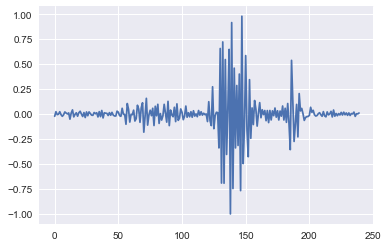

In [23]:
%matplotlib inline
print(df_features.loc[3].feature.shape)
import matplotlib.pyplot as plt
plt.plot(df_features.loc[3].feature)

In [24]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(df_features.feature.tolist())
y = np.array(df_features.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [25]:
x_train.shape

(1005, 240)

In [26]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [27]:
x_train.shape

(1005, 240, 1)

In [28]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 


num_labels = yy.shape[1]

# Construct model 
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
model = Sequential()

model.add(Conv1D(filters=4, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(filters=10, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(filters=20,kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(filters=40, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(150, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [29]:
# Display model architecture summary 
model.summary()
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]
print("Pre-training accuracy: %.4f%%" % accuracy) 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 238, 4)            16        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 119, 4)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 119, 4)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 117, 10)           130       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 58, 10)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 58, 10)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 56, 20)            620       
__________

In [30]:
import keras
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

class LivePlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()


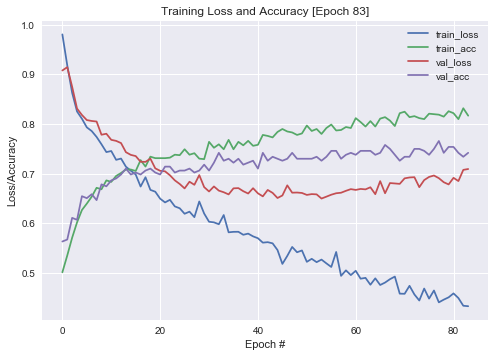

Training completed in time:  0:00:30.322983


In [31]:
#https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 120

es = EarlyStopping(monitor='val_loss', patience=30)
ch = ModelCheckpoint(filepath='data/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
callbacks = [es, ch, LivePlot()]
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(x_test, y_test), 
          verbose=1,
          callbacks=callbacks)


duration = datetime.now() - start
print("Training completed in time: ", duration)


In [32]:
path_weights = 'data/weights.best.basic_cnn.hdf5'
model.load_weights(path_weights)

# Evaluating the model on the training and testing set
score_t = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score_t[1])

score_v = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score_v[1])

Training Accuracy:  0.8288557215709591
Testing Accuracy:  0.7261904780826871


In [33]:
path_weights = 'data/weights.best.basic_cnn.hdf5'
model.load_weights(path_weights)

# Evaluating the model on the training and testing set
score_t = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score_t[1])

score_v = model.evaluate(x_test, y_test, verbose=0)
print("Val Accuracy: ", score_v[1])


features = []
for k,row in df_test_my.iterrows():
    data = extract_features(row['filename'])
    features.append([data])
df_features_test = pd.DataFrame(features, columns=['feature'])
print('Finished feature extraction from ', len(df_features_test), ' files')
X_test_my = np.array(df_features_test.feature.tolist())
x_test_my = np.expand_dims(X_test_my, axis=2)

le = LabelEncoder()
y_test_my = df_test_my.label.tolist()
Y_test_my = to_categorical(le.fit_transform(y_test_my)) 

#X_test_my = np.expand_dims(X_test_my, axis=2)

# Evaluating the model on the training and testing set
score_test = model.evaluate(x_test_my, Y_test_my, verbose=0)
print("Test Accuracy: ", score_test[1])


Training Accuracy:  0.8288557215709591
Val Accuracy:  0.7261904780826871
Finished feature extraction from  275  files
Test Accuracy:  0.7054545452378013


In [15]:
df_test_ = pd.read_csv(path_test)
df_test = df_test_.copy()
df_test['filename'] = df_test['filename'].map(lambda x: 'data/data/%04d.wav' % x)
print(len(df_test.index))
df_test.head(2)

1551


,filename
0,data/data/0001.wav
1,data/data/0002.wav


In [16]:
features = []
for k,row in df_test.iterrows():
    data = extract_features(row['filename'])
    features.append([data])
df_features_test = pd.DataFrame(features, columns=['feature'])
print('Finished feature extraction from ', len(df_features_test), ' files')


Finished feature extraction from  1551  files


In [17]:
X_test = np.array(df_features_test.feature.tolist())
X_test = np.expand_dims(X_test, axis=2)

In [23]:
X_test.shape

(1551, 880, 1)

In [18]:
y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)


In [19]:
len(X_test)

1551

In [20]:
y_classes

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
df_test_['label'] = y_classes

In [22]:
from datetime import datetime
now = datetime.now() # current date and time
timestamp = now.strftime("%Y%m%d_%H%M%S")
model_json = model.to_json()
model.save_weights('data/%s_weights.hdf5' % timestamp)
with open("data/%s_model.json" % timestamp, "w") as json_file:
    json_file.write(model_json)
df_test_.to_csv('data/%s_res.csv' % timestamp, index=None, header=None)
with open("data/%s_score.txt" % timestamp, "w") as file:
    scoring = "validation acc: %f - training acc: %f - sample rate: %i" % (score_v[1], score_t[1], sample_rate)
    file.write(scoring)

timestamp

'20191107_105837'